In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# profiling packages
from ydata_profiling import ProfileReport

# modeling packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE


# helper functions
from modeling_help import evaluate_model

In [166]:
# college football data
odds_df = pd.read_csv('data/Package Sample 20240511/ncaaf_game_scores_1g_2022_sample.csv')
odds_df.head(20)

,season,date,away_team,away_score,away_point_spread,away_point_spread_line,away_money_line,home_team,home_score,home_point_spread,home_point_spread_line,home_money_line,over_under,over_line,under_line
0,2022-23,2022-08-27,austin_peay,27,27.5,-112,0.0,western_kentucky,38,-27.5,-112,0.0,64.5,-109,-109
1,2022-23,2022-08-27,northwestern,31,11.0,-110,350.0,nebraska,28,-11.0,-110,-439.0,52.0,-110,-110
2,2022-23,2022-08-27,wyoming,6,14.0,-110,430.0,illinois,38,-14.0,-110,-550.0,43.0,-110,-110
3,2022-23,2022-08-27,idaho_state,21,23.0,-112,0.0,unlv,52,-23.0,-112,0.0,52.5,-109,-109
4,2022-23,2022-08-27,sf_austin,17,-6.5,-125,0.0,jacksonville_state,42,6.5,-105,0.0,51.5,-112,-112
5,2022-23,2022-08-27,connecticut,20,26.5,-110,1792.0,utah_state,31,-26.5,-110,-4615.0,59.5,-110,-110
6,2022-23,2022-08-27,duquesne,7,43.5,-105,0.0,florida_state,47,-43.5,-125,0.0,54.5,-112,-112
7,2022-23,2022-08-27,charlotte_u,13,7.0,-110,235.0,florida_atlantic,43,-7.0,-110,-275.0,59.0,-110,-110
8,2022-23,2022-08-27,florida_a&m,24,42.5,-109,0.0,north_carolina,56,-42.5,-114,0.0,55.5,-115,-115
9,2022-23,2022-08-27,north_texas,31,-1.5,-110,-122.0,utep,13,1.5,-110,102.0,54.5,-110,-110


In [167]:
odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season                  1224 non-null   object 
 1   date                    1224 non-null   object 
 2   away_team               1224 non-null   object 
 3   away_score              1224 non-null   int64  
 4   away_point_spread       1224 non-null   object 
 5   away_point_spread_line  1224 non-null   int64  
 6   away_money_line         1224 non-null   float64
 7   home_team               1224 non-null   object 
 8   home_score              1224 non-null   int64  
 9   home_point_spread       1224 non-null   float64
 10  home_point_spread_line  1224 non-null   int64  
 11  home_money_line         1224 non-null   float64
 12  over_under              1224 non-null   float64
 13  over_line               1224 non-null   int64  
 14  under_line              1224 non-null   

In [168]:
print(odds_df.season.value_counts())

season
2022-23    1224
Name: count, dtype: int64


## rough modeling just to understand predictive power

In [169]:
# drop columns
drop_cols = ['season', 'date']
odds_df.drop(drop_cols, axis=1, inplace=True)

odds_df.head()

,away_team,away_score,away_point_spread,away_point_spread_line,away_money_line,home_team,home_score,home_point_spread,home_point_spread_line,home_money_line,over_under,over_line,under_line
0,austin_peay,27,27.5,-112,0.0,western_kentucky,38,-27.5,-112,0.0,64.5,-109,-109
1,northwestern,31,11.0,-110,350.0,nebraska,28,-11.0,-110,-439.0,52.0,-110,-110
2,wyoming,6,14.0,-110,430.0,illinois,38,-14.0,-110,-550.0,43.0,-110,-110
3,idaho_state,21,23.0,-112,0.0,unlv,52,-23.0,-112,0.0,52.5,-109,-109
4,sf_austin,17,-6.5,-125,0.0,jacksonville_state,42,6.5,-105,0.0,51.5,-112,-112


In [170]:
# get unique values for away_team and home_team and put into 1 list
teams = list(odds_df.away_team.unique()) + list(odds_df.home_team.unique())
teams = list(set(teams))

# create a dictionary with team names as keys and values as integers
team_dict = {team: i for i, team in enumerate(teams)}

# map the team names to the integers
odds_df['away_team'] = odds_df['away_team'].map(team_dict)
odds_df['home_team'] = odds_df['home_team'].map(team_dict)
odds_df.head()

,away_team,away_score,away_point_spread,away_point_spread_line,away_money_line,home_team,home_score,home_point_spread,home_point_spread_line,home_money_line,over_under,over_line,under_line
0,17,27,27.5,-112,0.0,132,38,-27.5,-112,0.0,64.5,-109,-109
1,1,31,11.0,-110,350.0,61,28,-11.0,-110,-439.0,52.0,-110,-110
2,214,6,14.0,-110,430.0,121,38,-14.0,-110,-550.0,43.0,-110,-110
3,86,21,23.0,-112,0.0,215,52,-23.0,-112,0.0,52.5,-109,-109
4,44,17,-6.5,-125,0.0,105,42,6.5,-105,0.0,51.5,-112,-112


In [171]:
# odds_df[odds_df['away_point_spread'] == 'PK']

odds_df['away_point_spread'] = np.where(odds_df['away_point_spread'] == 'PK', (odds_df['home_point_spread'] * -1), odds_df['away_point_spread'])

odds_df['away_point_spread'] = pd.to_numeric(odds_df['away_point_spread'])
# odds_df.head()

# show me where the absolute value of away_point_spread and home_point_spread are not equal
odds_df[abs(odds_df['away_point_spread']) != abs(odds_df['home_point_spread'])]

,away_team,away_score,away_point_spread,away_point_spread_line,away_money_line,home_team,home_score,home_point_spread,home_point_spread_line,home_money_line,over_under,over_line,under_line
412,147,10,3.5,-112,140.0,84,24,-3.0,-107,-150.0,50.5,-115,-107
413,8,42,-10.0,-110,-365.0,215,7,10.5,-107,310.0,49.5,-110,-107
417,55,31,9.5,-110,300.0,193,52,-7.0,-110,-275.0,34.5,-115,-110
418,132,35,-7.5,-105,-275.0,223,17,8.0,-109,245.0,67.0,-107,-110
419,68,39,4.0,-109,150.0,25,10,-3.5,-105,-157.0,64.5,-105,-110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218,258,45,-7.5,-108,-300.0,3,20,25.5,-230,250.0,57.5,-108,-110
1220,199,46,2.5,-112,112.0,43,45,-1.5,-110,-120.0,64.0,-110,-108
1221,103,63,-9.0,-109,-335.0,149,7,15.5,-110,500.0,54.5,-109,-114
1222,51,35,-1.0,-110,-120.0,235,21,1.5,-110,106.0,54.0,-108,-112


In [172]:
# create a new column for the target variable as a binary outcome 1 for home team win and 0 for away team win
odds_df['target_money_line'] = odds_df['home_score'] > odds_df['away_score']
odds_df['target_money_line'] = odds_df['target_money_line'].astype(int)

## create targets for spread - we could predict a classification problem where we predict if the home team will cover the spread 
## or not or we could also train a model on the spread that actually happened and create a regressor model that will predict the spread itself
odds_df['spread_home_result_calc'] = odds_df['home_score'] - odds_df['away_score']
odds_df['spread_away_result_calc'] = odds_df['away_score'] - odds_df['home_score']

## this target column would be saying that the home team covered their spread prediction
odds_df['target_spread_home'] = (odds_df['spread_home_result_calc'] > abs(odds_df['home_point_spread'])) & (odds_df['home_point_spread'] < 0)
odds_df['target_spread_away'] = (odds_df['spread_away_result_calc'] > abs(odds_df['away_point_spread'])) & (odds_df['away_point_spread'] < 0)
odds_df['target_spread_home'] = odds_df['target_spread_home'].astype(int)
odds_df['target_spread_away'] = odds_df['target_spread_away'].astype(int)

## this taget is predicting 1 if the score went over the over under and 0 if it went under
odds_df['over_under_result'] = odds_df['home_score'] + odds_df['away_score']
odds_df['target_over_under'] = odds_df['over_under_result'] > odds_df['over_under']
odds_df['target_over_under'] = odds_df['target_over_under'].astype(int)

odds_df.head()

,away_team,away_score,away_point_spread,away_point_spread_line,away_money_line,home_team,home_score,home_point_spread,home_point_spread_line,home_money_line,over_under,over_line,under_line,target_money_line,spread_home_result_calc,spread_away_result_calc,target_spread_home,target_spread_away,over_under_result,target_over_under
0,17,27,27.5,-112,0.0,132,38,-27.5,-112,0.0,64.5,-109,-109,1,11,-11,0,0,65,1
1,1,31,11.0,-110,350.0,61,28,-11.0,-110,-439.0,52.0,-110,-110,0,-3,3,0,0,59,1
2,214,6,14.0,-110,430.0,121,38,-14.0,-110,-550.0,43.0,-110,-110,1,32,-32,1,0,44,1
3,86,21,23.0,-112,0.0,215,52,-23.0,-112,0.0,52.5,-109,-109,1,31,-31,1,0,73,1
4,44,17,-6.5,-125,0.0,105,42,6.5,-105,0.0,51.5,-112,-112,1,25,-25,0,0,59,1


In [173]:
## spread_example
odds_df[['away_score', 'home_score', 'spread_home_result_calc', 'spread_away_result_calc', 'away_point_spread', 'home_point_spread', 'target_spread_home', 'target_spread_away']].head(10)

,away_score,home_score,spread_home_result_calc,spread_away_result_calc,away_point_spread,home_point_spread,target_spread_home,target_spread_away
0,27,38,11,-11,27.5,-27.5,0,0
1,31,28,-3,3,11.0,-11.0,0,0
2,6,38,32,-32,14.0,-14.0,1,0
3,21,52,31,-31,23.0,-23.0,1,0
4,17,42,25,-25,-6.5,6.5,0,0
5,20,31,11,-11,26.5,-26.5,0,0
6,7,47,40,-40,43.5,-43.5,0,0
7,13,43,30,-30,7.0,-7.0,1,0
8,24,56,32,-32,42.5,-42.5,0,0
9,31,13,-18,18,-1.5,1.5,0,1


In [174]:
odds_df['target_over_under'].value_counts()

target_over_under
1    626
0    598
Name: count, dtype: int64

In [175]:
odds_df['target_spread_home'].value_counts()

target_spread_home
0    865
1    359
Name: count, dtype: int64

In [176]:
odds_df['target_spread_away'].value_counts()

target_spread_away
0    1019
1     205
Name: count, dtype: int64

In [177]:
odds_df['target_money_line'].value_counts()

target_money_line
1    725
0    499
Name: count, dtype: int64

In [178]:
# check if there is ever a tie
odds_df[odds_df['home_score'] == odds_df['away_score']]

,away_team,away_score,away_point_spread,away_point_spread_line,away_money_line,home_team,home_score,home_point_spread,home_point_spread_line,home_money_line,over_under,over_line,under_line,target_money_line,spread_home_result_calc,spread_away_result_calc,target_spread_home,target_spread_away,over_under_result,target_over_under


In [179]:
# # where away_point_spread == 'PK' set to the opposite of home_point_spread
# odds_df.loc[odds_df['away_point_spread'] == 'PK', 'away_point_spread'] = odds_df['home_point_spread'] * -1
# odds_df['away_point_spread'] = odds_df['away_point_spread'].astype(float)

# # show odds_df at index 841, 1058, and 1146
# odds_df.loc[[841, 1058, 1146]]

In [180]:
# remove home score and away score columns and store into a new dataframe
df_model_ready = odds_df.drop(['home_score', 'away_score'], axis=1)

# # create x and y variables
# X = df_model_ready.drop('target', axis=1)
# y = df_model_ready['target']

# # split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.head()

## Spead Models

In [189]:
# create x and y variables
X_spread_home = df_model_ready.drop(['target_money_line', 'spread_away_result_calc', 'spread_home_result_calc', 'target_spread_home', 'target_spread_away', 'over_under_result', 'target_over_under', 'away_team', 'home_team'], axis=1)
# X_spread_home = df_model_ready.drop(['target_money_line', 'spread_away_result_calc', 'spread_home_result_calc', 'target_spread_home', 'target_spread_away', 'over_under_result', 'target_over_under'], axis=1)
y_spread_home = df_model_ready['target_spread_home']

# split the data into training and testing sets
X_train_spread_home, X_test_spread_home, y_train_spread_home, y_test_spread_home= train_test_split(X_spread_home, y_spread_home, test_size=0.2, random_state=42)

In [190]:
# create x and y variables
X_spread_away = df_model_ready.drop(['target_money_line', 'spread_away_result_calc', 'spread_home_result_calc', 'target_spread_home', 'target_spread_away', 'over_under_result', 'target_over_under', 'away_team', 'home_team'], axis=1)
# X_spread_away = df_model_ready.drop(['target_money_line', 'spread_away_result_calc', 'spread_home_result_calc', 'target_spread_home', 'target_spread_away', 'over_under_result', 'target_over_under'], axis=1)
y_spread_away = df_model_ready['target_spread_away']

# split the data into training and testing sets
X_train_spread_away, X_test_spread_away, y_train_spread_away, y_test_spread_away= train_test_split(X_spread_away, y_spread_away, test_size=0.2, random_state=42)

### logistic reg

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Model Evaluation on Test Data:
Accuracy: 0.6938775510204082
ROC AUC Score: 0.6763780132043605
[[121  46]
 [ 29  49]]
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       167
           1       0.52      0.63      0.57        78

    accuracy                           0.69       245
   macro avg       0.66      0.68      0.66       245
weighted avg       0.71      0.69      0.70       245



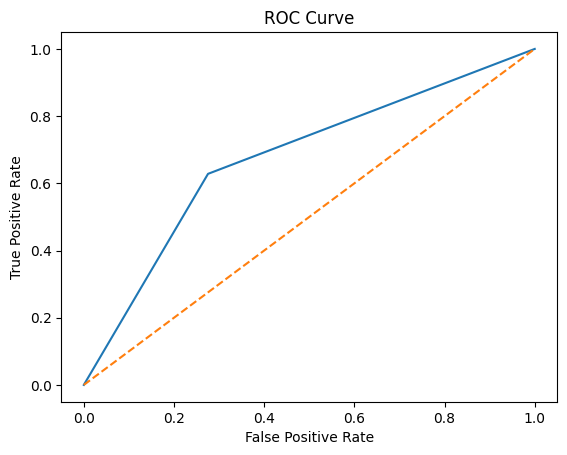

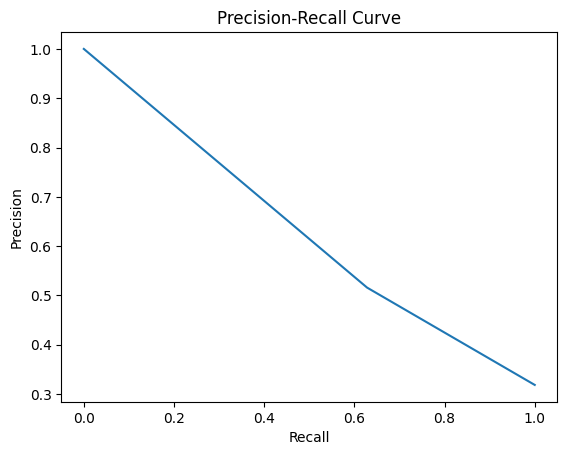

Model Evaluation on Train Data: Want to see how this may be overfitting...
Accuracy: 0.6755014326647565
ROC AUC Score: 0.6755014326647566
[[491 207]
 [246 452]]
              precision    recall  f1-score   support

           0       0.67      0.70      0.68       698
           1       0.69      0.65      0.67       698

    accuracy                           0.68      1396
   macro avg       0.68      0.68      0.68      1396
weighted avg       0.68      0.68      0.68      1396



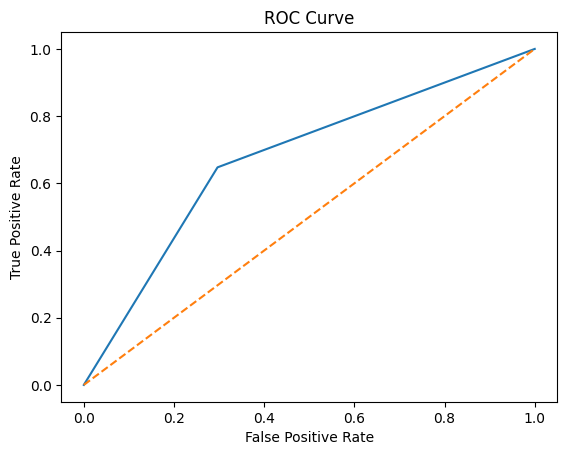

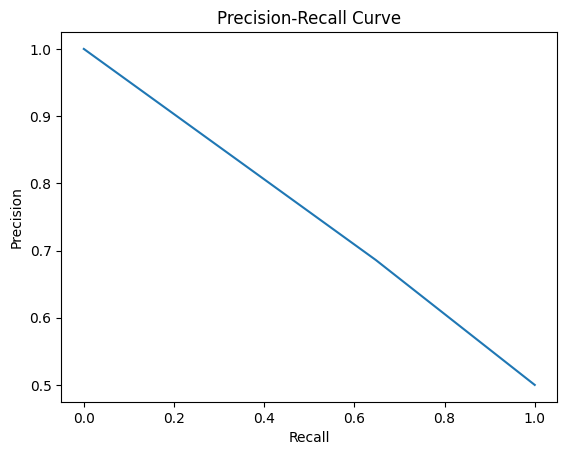

In [206]:
# create a dictionary of hyperparameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}
# create a grid search object
grid_log_reg = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc')

# use smote to oversample the minority class
smote = SMOTE(random_state=42)
X_train_spread_home, y_train_spread_home = smote.fit_resample(X_train_spread_home, y_train_spread_home)

# fit the grid search object to the training data
grid_log_reg.fit(X_train_spread_home, y_train_spread_home)

# get the best hyperparameters
print(grid_log_reg.best_params_)

# create a logistic regression model with the best hyperparameters from grid_log_reg.best_params_
log_reg_model = LogisticRegression(C=10, penalty='l1', solver='liblinear')

# use evaluate_model function to evaluate the model
accuracy_log_reg, roc_auc_score_var_log_reg, conf_matrix_log_reg, class_report_log_reg, fpr_log_reg, tpr_log_reg, precision_log_reg, recall_log_reg = evaluate_model(log_reg_model, X_train_spread_home, y_train_spread_home, X_test_spread_home, y_test_spread_home)

# save this log_reg_model to a pickle file
import pickle
with open('models/home_spread_log_reg_model.pkl', 'wb') as f:
    pickle.dump(log_reg_model, f)

In [207]:
X_test_spread_away.head()

,away_point_spread,away_point_spread_line,away_money_line,home_point_spread,home_point_spread_line,home_money_line,over_under,over_line,under_line
661,18.0,-110,800.0,-17.5,-110,-900.0,56.5,-109,-107
220,-2.0,-115,-135.0,2.0,-105,115.0,50.5,-110,-110
155,30.0,-110,8000.0,-30.0,-110,-20000.0,53.0,-109,-109
677,2.5,-104,120.0,-2.0,-120,-135.0,54.5,-105,-107
911,-7.0,-110,-275.0,8.0,-110,250.0,47.0,-110,-110


{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Model Evaluation on Test Data:
Accuracy: 0.8163265306122449
ROC AUC Score: 0.8608374384236455
[[161  42]
 [  3  39]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       203
           1       0.48      0.93      0.63        42

    accuracy                           0.82       245
   macro avg       0.73      0.86      0.76       245
weighted avg       0.90      0.82      0.84       245



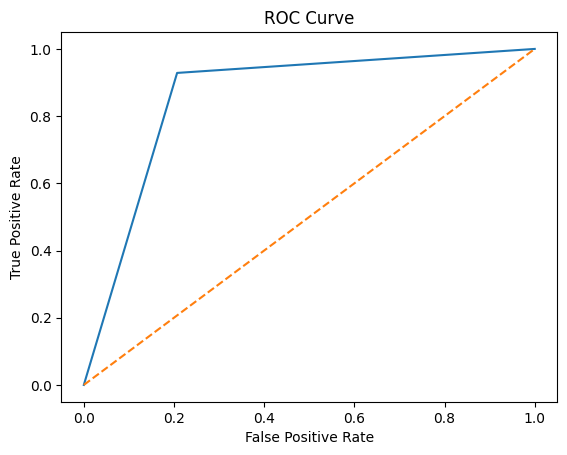

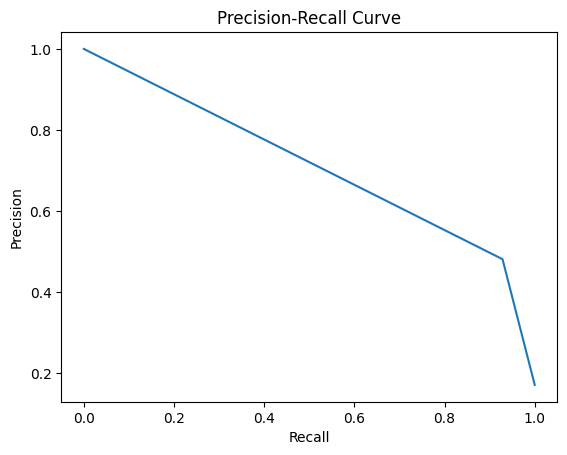

Model Evaluation on Train Data: Want to see how this may be overfitting...
Accuracy: 0.8535539215686274
ROC AUC Score: 0.8535539215686274
[[649 167]
 [ 72 744]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.84       816
           1       0.82      0.91      0.86       816

    accuracy                           0.85      1632
   macro avg       0.86      0.85      0.85      1632
weighted avg       0.86      0.85      0.85      1632



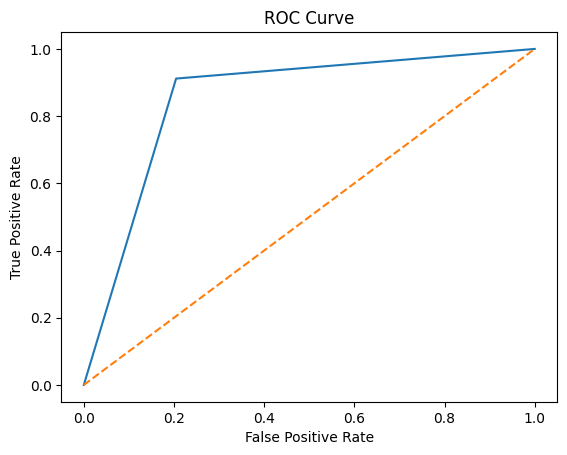

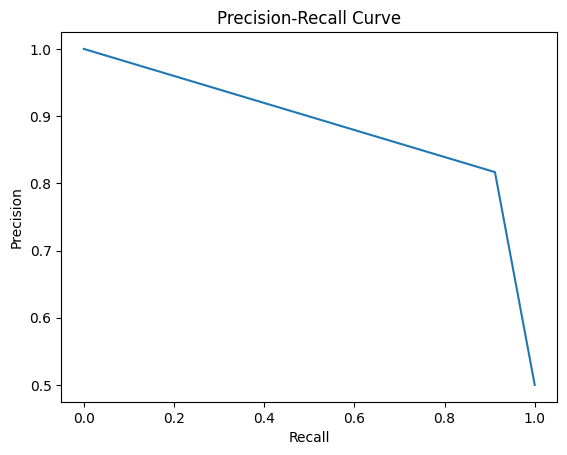

In [205]:
# create a dictionary of hyperparameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}
# create a grid search object
grid_log_reg = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc')

# use smote to oversample the minority class
smote = SMOTE(random_state=42)
X_train_spread_away, y_train_spread_away = smote.fit_resample(X_train_spread_away, y_train_spread_away)

# fit the grid search object to the training data
grid_log_reg.fit(X_train_spread_home, y_train_spread_home)

# get the best hyperparameters
print(grid_log_reg.best_params_)

# create a logistic regression model with the best hyperparameters from grid_log_reg.best_params_
log_reg_model = LogisticRegression(C=10, penalty='l1', solver='liblinear')

# use evaluate_model function to evaluate the model
accuracy_log_reg, roc_auc_score_var_log_reg, conf_matrix_log_reg, class_report_log_reg, fpr_log_reg, tpr_log_reg, precision_log_reg, recall_log_reg = evaluate_model(log_reg_model, X_train_spread_away, y_train_spread_away, X_test_spread_away, y_test_spread_away)

# save this log_reg_model to a pickle file
import pickle
with open('models/away_spread_log_reg_model.pkl', 'wb') as f:
    pickle.dump(log_reg_model, f)

### random forest

In [90]:
# # create a dictionary of hyperparameters
# param_grid = {
#     'n_estimators': [5, 10, 20, 50],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # create a grid search object
# grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1)

# # fit the grid search object to the data
# grid_search.fit(X_train_spread, y_train_spread)

# # get the best hyperparameters
# print(grid_search.best_params_)

# # create a random forest classifier with the best hyperparameters
# rf_model = RandomForestClassifier(**grid_search.best_params_)

# accuracy_rf, roc_auc_score_var_rf, conf_matrix_rf, class_report_rf, fpr_rf, tpr_rf, precision_rf, recall_rf = evaluate_model(rf_model, X_train_spread, y_train_spread, X_test_spread, y_test_spread)

### lgb classifier

In [91]:
# # create a dictionary of hyperparameters
# param_grid = {
#     'n_estimators': [5, 10, 20, 50],
#     'max_depth': [5, 10, 15],
#     'learning_rate': [0.01, 0.1, 1]
# }

# # create a grid search object
# grid_search = GridSearchCV(LGBMClassifier(), param_grid, cv=3, n_jobs=-1)

# # fit the grid search object to the data
# grid_search.fit(X_train_spread, y_train_spread)

# # get the best hyperparameters
# print(grid_search.best_params_)

# # create a lightgbm classifier with the best hyperparameters
# lgbm_model = LGBMClassifier(**grid_search.best_params_)
# accuracy_lgbm, roc_auc_score_var_lgbm, conf_matrix_lgbm, class_report_lgbm, fpr_lgbm, tpr_lgbm, precision_lgbm, recall_lgbm = evaluate_model(lgbm_model, X_train_spread, y_train_spread, X_test_spread, y_test_spread)

## Over / Under Models

In [92]:
# create x and y variables
X_ou = df_model_ready.drop(['target_money_line', 'spread_away_result_calc', 'spread_home_result_calc', 'target_spread_home', 'target_spread_away', 'over_under_result', 'target_over_under'], axis=1)
y_ou = df_model_ready['target_over_under']

# split the data into training and testing sets
X_train_ou, X_test_ou, y_train_ou, y_test_ou = train_test_split(X_ou, y_ou, test_size=0.2, random_state=42)

### logistic reg

{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Model Evaluation on Test Data:
Accuracy: 0.5224489795918368
ROC AUC Score: 0.4925338154546672
[[  7 107]
 [ 10 121]]
              precision    recall  f1-score   support

           0       0.41      0.06      0.11       114
           1       0.53      0.92      0.67       131

    accuracy                           0.52       245
   macro avg       0.47      0.49      0.39       245
weighted avg       0.48      0.52      0.41       245



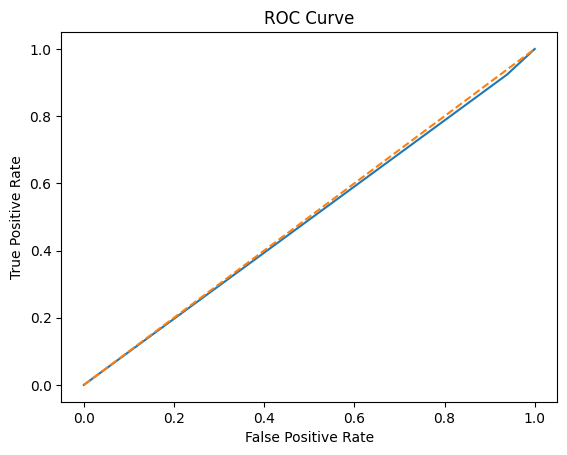

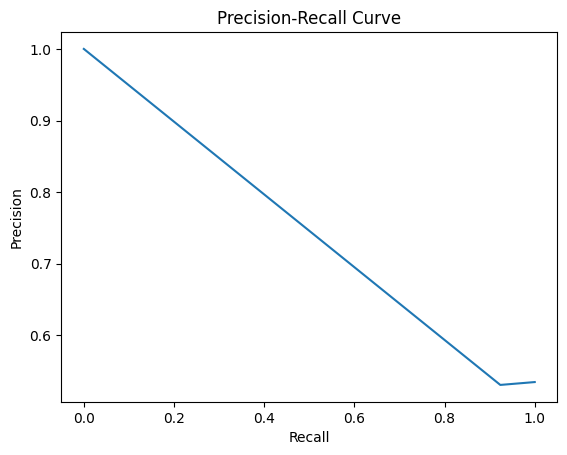

Model Evaluation on Train Data: Want to see how this may be overfitting...
Accuracy: 0.5066394279877426
ROC AUC Score: 0.502020202020202
[[ 44 440]
 [ 43 452]]
              precision    recall  f1-score   support

           0       0.51      0.09      0.15       484
           1       0.51      0.91      0.65       495

    accuracy                           0.51       979
   macro avg       0.51      0.50      0.40       979
weighted avg       0.51      0.51      0.41       979



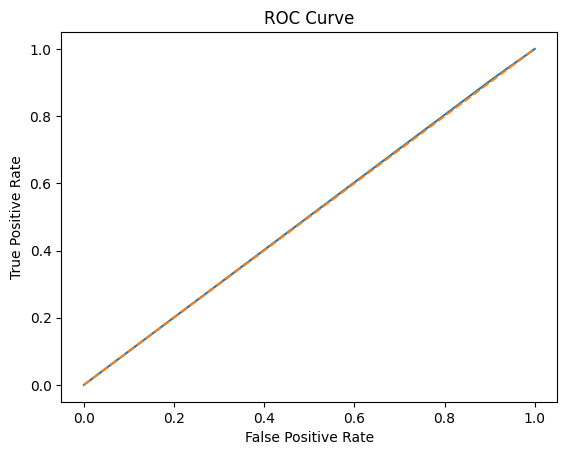

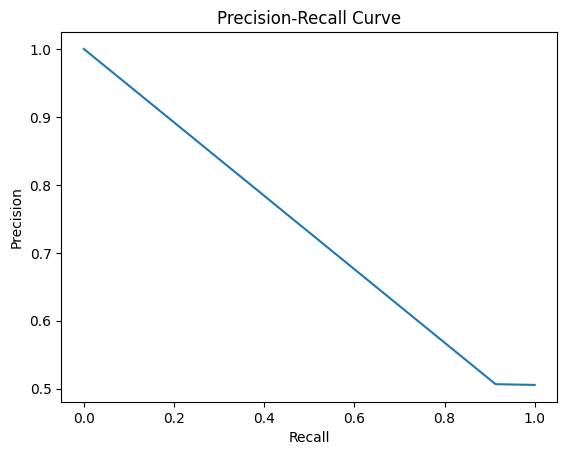

In [93]:
# create a dictionary of hyperparameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}
# create a grid search object
grid_log_reg = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc')

# fit the grid search object to the training data
grid_log_reg.fit(X_train_ou, y_train_ou)

# get the best hyperparameters
print(grid_log_reg.best_params_)

# create a logistic regression model with the best hyperparameters from grid_log_reg.best_params_
log_reg_model = LogisticRegression(C=0.001, penalty='l1', solver='liblinear')

# use evaluate_model function to evaluate the model
accuracy_log_reg, roc_auc_score_var_log_reg, conf_matrix_log_reg, class_report_log_reg, fpr_log_reg, tpr_log_reg, precision_log_reg, recall_log_reg = evaluate_model(log_reg_model, X_train_ou, y_train_ou, X_test_ou, y_test_ou)

### random forest

In [94]:
# # create a dictionary of hyperparameters
# param_grid = {
#     'n_estimators': [5, 10, 50, 100, 200],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # create a grid search object
# grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1)

# # fit the grid search object to the data
# grid_search.fit(X_train_ou, y_train_ou)

# # get the best hyperparameters
# grid_search.best_params_

# # create a random forest classifier with the best hyperparameters
# rf_model = RandomForestClassifier(**grid_search.best_params_)

# accuracy_rf, roc_auc_score_var_rf, conf_matrix_rf, class_report_rf, fpr_rf, tpr_rf, precision_rf, recall_rf = evaluate_model(rf_model, X_train_ou, y_train_ou, X_test_ou, y_test_ou)

### lgb classifier

In [95]:
# # create a dictionary of hyperparameters
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 15],
#     'learning_rate': [0.01, 0.1, 1]
# }

# # create a grid search object
# grid_search = GridSearchCV(LGBMClassifier(), param_grid, cv=3, n_jobs=-1)

# # fit the grid search object to the data
# grid_search.fit(X_train, y_train)

# # get the best hyperparameters
# grid_search.best_params_

# # create a lightgbm classifier with the best hyperparameters
# lgbm_model = LGBMClassifier(**grid_search.best_params_)
# accuracy_lgbm, roc_auc_score_var_lgbm, conf_matrix_lgbm, class_report_lgbm, fpr_lgbm, tpr_lgbm, precision_lgbm, recall_lgbm = evaluate_model(lgbm_model, X_train_ou, y_train_ou, X_test_ou, y_test_ou)

## Money Line Models

In [199]:
# create x and y variables
X_ml = df_model_ready.drop(['target_money_line', 'spread_away_result_calc', 'spread_home_result_calc', 'target_spread_home', 'target_spread_away', 'over_under_result', 'target_over_under', 'home_team', 'away_team'], axis=1)
# X_ml = df_model_ready.drop(['target_money_line', 'spread_away_result_calc', 'spread_home_result_calc', 'target_spread_home', 'target_spread_away', 'over_under_result', 'target_over_under'], axis=1)
y_ml = df_model_ready['target_money_line']

# split the data into training and testing sets
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

### logistic regression

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Model Evaluation on Test Data:
Accuracy: 0.710204081632653
ROC AUC Score: 0.7017543859649125
[[ 62  31]
 [ 40 112]]
              precision    recall  f1-score   support

           0       0.61      0.67      0.64        93
           1       0.78      0.74      0.76       152

    accuracy                           0.71       245
   macro avg       0.70      0.70      0.70       245
weighted avg       0.72      0.71      0.71       245



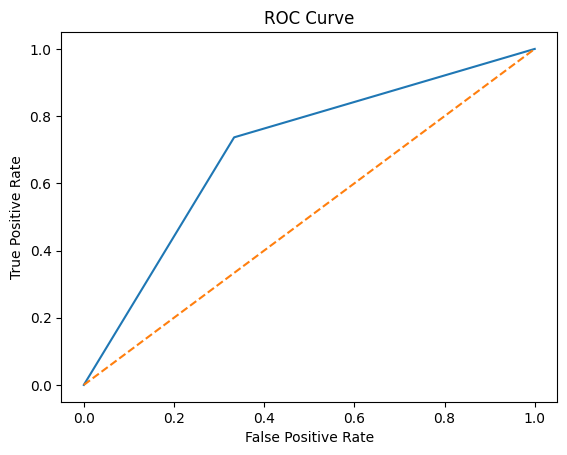

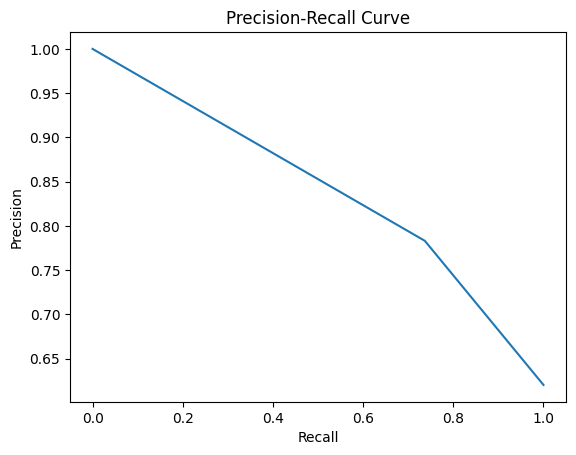

Model Evaluation on Train Data: Want to see how this may be overfitting...
Accuracy: 0.7460732984293194
ROC AUC Score: 0.7460732984293195
[[424 149]
 [142 431]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       573
           1       0.74      0.75      0.75       573

    accuracy                           0.75      1146
   macro avg       0.75      0.75      0.75      1146
weighted avg       0.75      0.75      0.75      1146



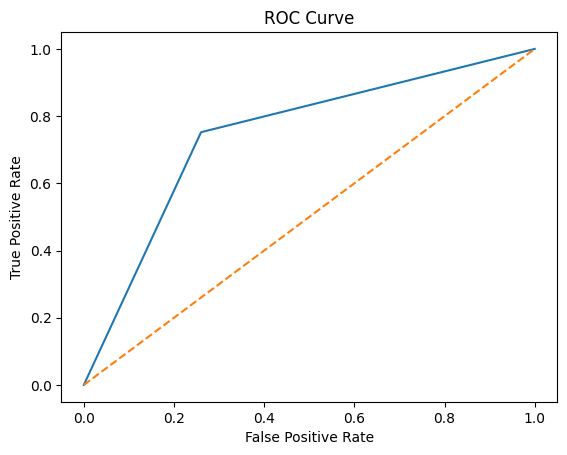

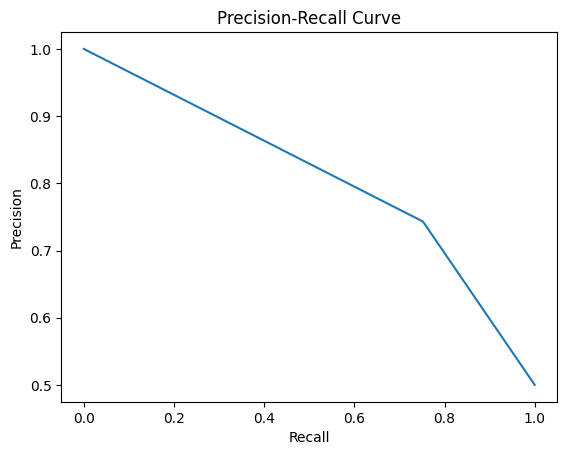

In [204]:
# create a logistic regression model
# log_reg_model = LogisticRegression()

# perform hyperparameter tuning using GridSearchCV
# create a dictionary of hyperparameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']}
# create a grid search object
grid_log_reg = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc')

# use smote to oversample the minority class
smote = SMOTE(random_state=42)
X_train_ml, y_train_ml = smote.fit_resample(X_train_ml, y_train_ml)

# fit the grid search object to the training data
grid_log_reg.fit(X_train_ml, y_train_ml)

# get the best hyperparameters
print(grid_log_reg.best_params_)

# create a logistic regression model with the best hyperparameters from grid_log_reg.best_params_
log_reg_model = LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

# # open this model from above
# with open('models/money_line_log_reg_model.pkl', 'rb') as f:
#     log_reg_model = pickle.load(f)

# use evaluate_model function to evaluate the model
accuracy_log_reg, roc_auc_score_var_log_reg, conf_matrix_log_reg, class_report_log_reg, fpr_log_reg, tpr_log_reg, precision_log_reg, recall_log_reg = evaluate_model(log_reg_model, X_train_ml, y_train_ml, X_test_ml, y_test_ml)

with open('models/money_line_log_reg_model.pkl', 'wb') as f:
    pickle.dump(log_reg_model, f)

### random forest classifier

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 15}
Model Evaluation on Test Data:
Accuracy: 0.7142857142857143
ROC AUC Score: 0.7050438596491229
[[ 62  31]
 [ 39 113]]
              precision    recall  f1-score   support

           0       0.61      0.67      0.64        93
           1       0.78      0.74      0.76       152

    accuracy                           0.71       245
   macro avg       0.70      0.71      0.70       245
weighted avg       0.72      0.71      0.72       245



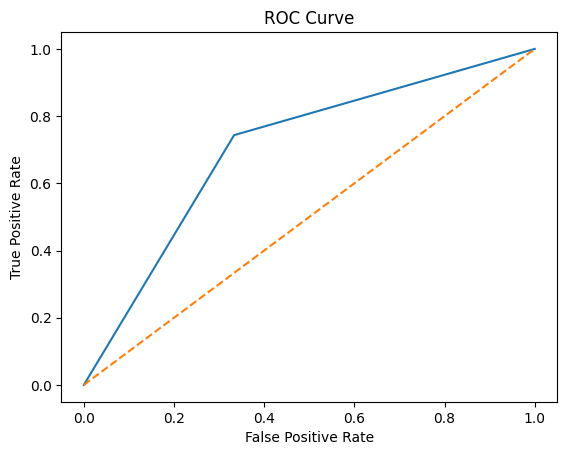

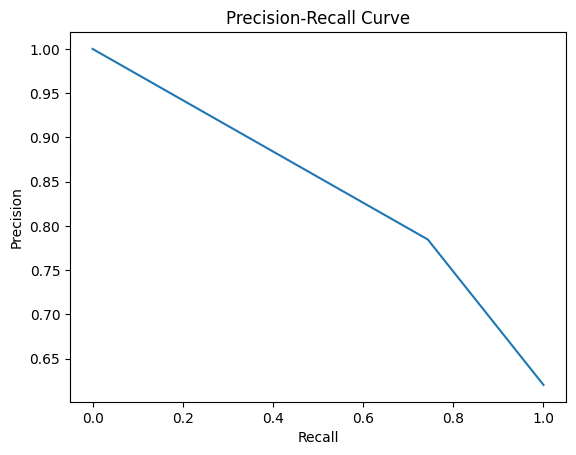

Model Evaluation on Train Data: Want to see how this may be overfitting...
Accuracy: 0.8900523560209425
ROC AUC Score: 0.8900523560209423
[[508  65]
 [ 61 512]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       573
           1       0.89      0.89      0.89       573

    accuracy                           0.89      1146
   macro avg       0.89      0.89      0.89      1146
weighted avg       0.89      0.89      0.89      1146



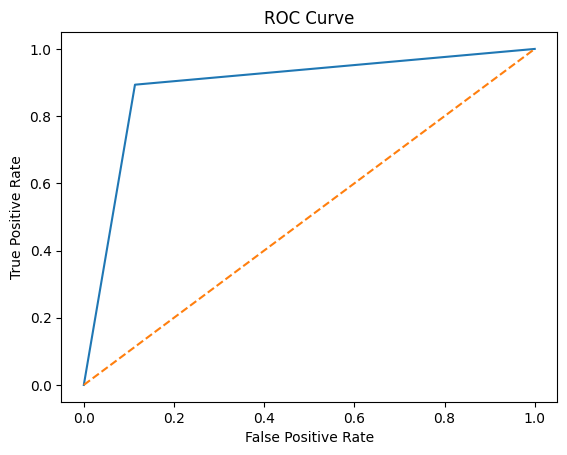

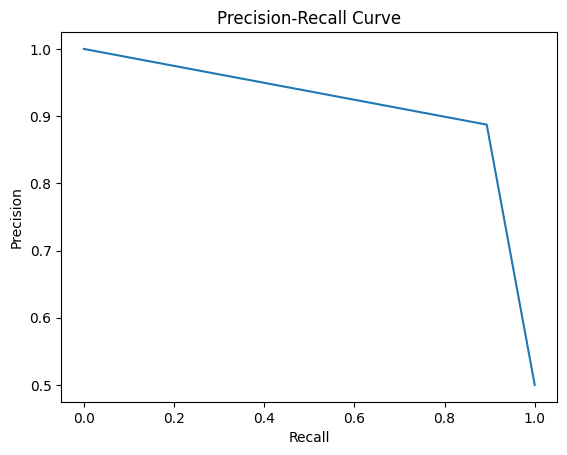

In [99]:
# create a random forest classifier
# rf_model = RandomForestClassifier() -- overfitting very badly

# perform hyperparameter tuning using grid search

# create a dictionary of hyperparameters
param_grid = {
    'n_estimators': [5, 10, 15, 20, 30],
    'max_depth': [1, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# create a grid search object
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train_ml, y_train_ml)

# get the best hyperparameters
print(grid_search.best_params_)

# create a random forest classifier with the best hyperparameters
rf_model = RandomForestClassifier(**grid_search.best_params_)

accuracy_rf, roc_auc_score_var_rf, conf_matrix_rf, class_report_rf, fpr_rf, tpr_rf, precision_rf, recall_rf = evaluate_model(rf_model, X_train_ml, y_train_ml, X_test_ml, y_test_ml)

### lgb classifier

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 573, number of negative: 573
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1502
[LightGBM] [Info] Number of data points in the train set: 1146, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

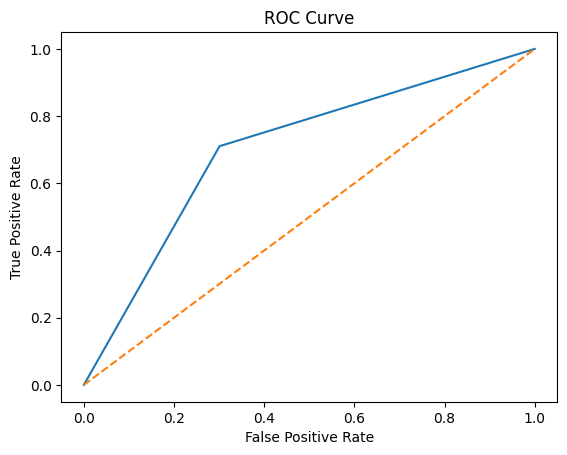

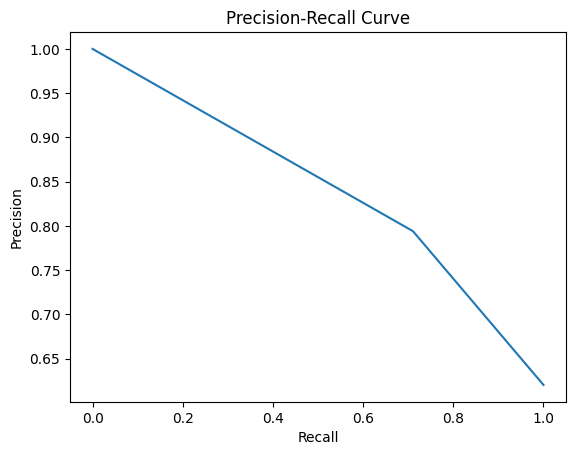

Model Evaluation on Train Data: Want to see how this may be overfitting...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 0.7958115183246073
ROC AUC Score: 0.7958115183246074
[[472 101]
 [133 440]]
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       573
           1       0.81      0.77      0.79       573

    accuracy                           0.80      1146
   macro avg       0.80      0.80      0.80      1146
weighted avg       0.80      0.80      0.80      1146



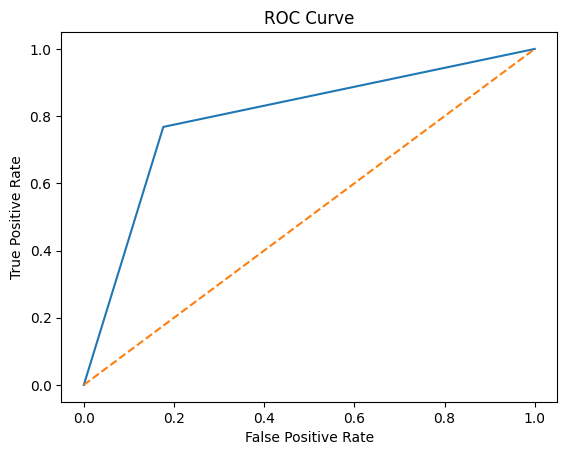

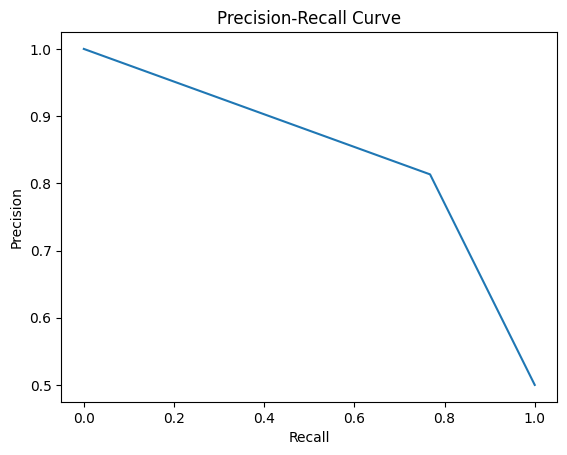

In [101]:
# # create a lightgbm classifier
# lgbm_model = LGBMClassifier()

# perform hyperparameter tuning using grid search

# create a dictionary of hyperparameters
param_grid = {
    'n_estimators': [5, 10, 15, 20, 30],
    'max_depth': [1, 3, 5, 10, 15],
    'learning_rate': [0.01, 0.1, 1]
}

# create a grid search object
grid_search = GridSearchCV(LGBMClassifier(), param_grid, cv=3, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train_ml, y_train_ml)

# get the best hyperparameters
grid_search.best_params_

# create a lightgbm classifier with the best hyperparameters
lgbm_model = LGBMClassifier(**grid_search.best_params_)
accuracy_lgbm, roc_auc_score_var_lgbm, conf_matrix_lgbm, class_report_lgbm, fpr_lgbm, tpr_lgbm, precision_lgbm, recall_lgbm = evaluate_model(lgbm_model, X_train_ml, y_train_ml, X_test_ml, y_test_ml)